In this file I'm going to produce a map that shows the distance to nearest bus stop (in use) from 250m x 250m grid square centroids.

In [ ]:
# Importing necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import pyproj

In [7]:
# Reading HSL_stops data to GeoDataFrame
fp = r'HSL_stops.shp'
bus_stops = gpd.read_file(fp)

# Reading the grid data to GeoDataFrame
fp = r"MetropAccess_YKR_grid_EurefFIN.shp"
grid = gpd.read_file(fp, sep=";")

# Setting crs to WGS84
grid = grid.to_crs(epsg=4326)

# Calculating centroid points to grid squares and setting it to geometry column
grid["centroid"] = grid.centroid
grid = grid.set_geometry("centroid")

# Changing the bus_stops' crs to WGS84 as well
bus_stops = bus_stops.to_crs(crs=grid.crs)

# Making sure they are the same crs
bus_stops.crs == grid.crs

<ipython-input-7-6f5a1bef57c2>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["centroid"] = grid.centroid


True

In [8]:
# Selecting only bus stops from the data
bus_stops = bus_stops.loc[bus_stops["VERKKO"] == 1]

# Selecting only the stops in use
bus_stops = bus_stops.loc[bus_stops["REI_VOIM"] == 1]

In [9]:
# Importing modules
import shapely.speedups
shapely.speedups.enable()
from sklearn.neighbors import BallTree
import numpy as np


def get_nearest(src_points, candidates, k_neighbors=1):
    """This function finds the nearest bus stop from all the grid square centroids"""

    # Creating tree from all the possible stops
    tree = BallTree(candidates, leaf_size=12, metric='haversine')

    # Finding the closest stops and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Closest indices and distances
    closest = indices[0]
    closest_dist = distances[0]

    # Returning indices and distances
    return (closest, closest_dist)

def nearest_neighbor(frst_gdf, scnd_gdf, return_dist=False):
    """This function finds the nearest points in scnd_gdf for each point in the frst_gdf"""
    
    frst_geom_col = frst_gdf.geometry.name
    scnd_geom_col = scnd_gdf.geometry.name
    
    # Making sure that the index in scnd_gdf is formed of sequencal numbers
    scnd = scnd_gdf.copy().reset_index(drop=True)
    
    # Parsing coordinates from points and inserting them into a numpy array as radians
    frst_radians = np.array(frst_gdf[frst_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    scnd_radians = np.array(scnd[scnd_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Getting the corresponding indices and distance between nearest neighbours
    closest, dist = get_nearest(src_points=frst_radians, candidates=scnd_radians)

    # Returns the closest points from scnd_gdf to frst_gdf
    closest_points = scnd.loc[closest]
    
    # Ensuring that the scnd_gdf indices correspond to frst_gdf indices
    closest_points = closest_points.reset_index(drop=True)
    
    # Converting to meters from radians, calculating distances 
    if return_dist:
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

# Finding closest bus stops for each grid centroid and returning the havershine distance
closest_stops = nearest_neighbor(grid, bus_stops, return_dist=True)

closest_stops.head(5)

,FID,SOLMUTUNNU,LYHYTTUNNU,SOLMUTYYPP,X,Y,PROJ_X,PROJ_Y,NIMI1,NAMN1,NIMI2,NAMN2,REI_VOIM,AIK_VOIM,VERKKO,PYSAKKITYY,geometry,distance
0,8171,4320213,V3213,P,2546367,6697484,2546349,6697478,Reunakuja,Reunagränden,Riipiläntie,Ripubyvägen,1,1,1,04,POINT (24.83753 60.38574),2506.994850
1,12533,9700204,Nu8377,P,2548036,6701403,2548028,6701398,Palojoki,Palojoki,None,None,1,1,1,99,POINT (24.86873 60.42072),2277.351600
2,12530,9700201,Nu8380,P,2548512,6700633,2548513,6700633,Paloonmäki,Paloonmäki,Palojoentie,Palojoentie,1,1,1,99,POINT (24.87718 60.41375),1924.755902
3,12530,9700201,Nu8380,P,2548512,6700633,2548513,6700633,Paloonmäki,Paloonmäki,Palojoentie,Palojoentie,1,1,1,99,POINT (24.87718 60.41375),1607.543074
4,8178,4320220,V3220,P,2546121,6698318,2546113,6698310,Lammintie,Lammivägen,Riipiläntie,Ripubyvägen,1,1,1,04,POINT (24.83326 60.39325),1120.329861


In [10]:
# Making sure that the
print(len(closest_stops), '==', len(grid))

13231 == 13231


In [11]:
# Renaming the closest_stops' geometry column and merging datasets
closest_stops = closest_stops.rename(columns={'geometry': 'closest_stop_geom'})
grid = grid.join(closest_stops)

In [13]:
# Watching some statistics. It looks like one shouldn't walk over 400 meters to bus_stops from most of the grid square centroids.
grid["distance"].describe()

count    13231.000000
mean       589.310699
std        578.497459
min          2.678061
25%        194.725085
50%        382.393797
75%        780.023775
max       3494.510108
Name: distance, dtype: float64

In [14]:
# Setting the grid crs to Pseudo-Mercator for visualization
grid = grid.to_crs(epsg=3857)
grid.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

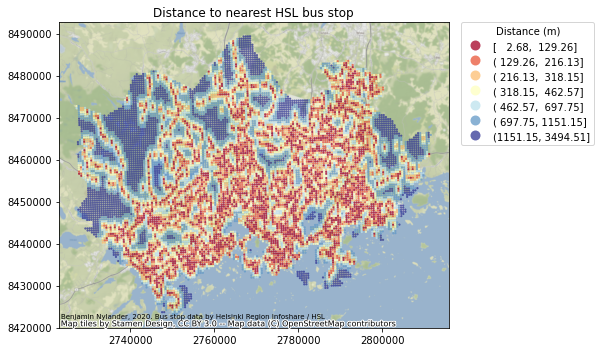

In [18]:
# Importing modules
import matplotlib
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Creating subplot and setting figzize
fig, ax = plt.subplots(figsize=(10,5))

# Visualizing the distances into 7 classes using "Red-Yellow-Blue" colormap and "Quantiles" classification scheme
grid.plot(ax=ax, column="distance", markersize=5.0, alpha=0.75, linewidth=0, cmap="RdYlBu", scheme="quantiles", k=7, legend=True)

# Setting title
ax.set_title("Distance to nearest HSL bus stop")

# Re-positioning the legend and setting title
ax.get_legend().set_bbox_to_anchor((1.02,1.018))
ax.get_legend().set_title("Distance (m)")

# Showing the coordinates as a whole
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

# Adding basemap
ctx.add_basemap(ax, zoom=12)

# Adding text to give credits, setting it to bottom left corner
t = ("Benjamin Nylander, 2020. Bus stop data by Helsinki Region Infoshare / HSL")
plt.text(2723500, 8422300, t, fontsize=7)

#Removing unnecessary whitespace
plt.tight_layout()

# Saving figure as png image
output_fig = "docs/distance_to_bus_stop.png"
plt.savefig(output_fig)

<Figure size 432x288 with 0 Axes>